In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

In [3]:
df = pd.read_csv('final_data_endelig_endelig.csv')
df_upcoming = pd.read_csv('test_data.csv')

C:\Users\vtodd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.shape

(9250, 458)

In [5]:
df_upcoming.shape

(23, 458)

In [6]:
y = df['price']

#only taking values, where we don't have a zero count across all observations
X = df.drop(columns = ['name', 'release_date', 'developer','price', 'id'])

In [7]:
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()
# X['developer'] = LE.fit_transform(X['developer'])
X.age = X.age.astype('str').str.rstrip('+').astype(int)

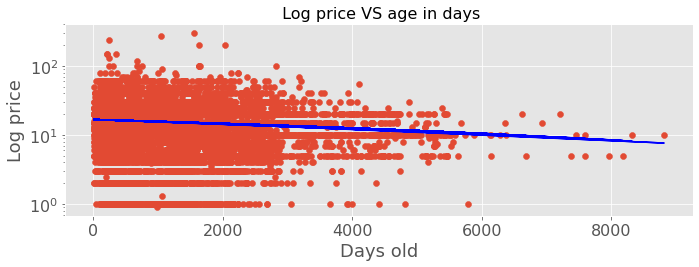

In [55]:
fig = plt.figure()
plt.yscale('log')
plt.title(' Log price VS age in days')
plt.xlabel('Days old')
plt.ylabel('Log price')
plt.scatter(X['time_delta'], y)
m, b = np.polyfit(X['time_delta'], y, 1)
plt.plot(X['time_delta'], m*X['time_delta'] + b, color = 'blue')
fig.tight_layout()

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [10]:
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, test_size = 2/10, random_state = 1337)

In [11]:
X_scaled = StandardScaler().fit_transform(X_dev)

In [12]:
X_scaled.shape

(7400, 453)

In [13]:
from sklearn.decomposition import PCA

pcamodel = PCA(n_components = 453)
pcamodel.fit(X_scaled)

PCA(n_components=453)

In [14]:
for i in range(453):
    if sum(pcamodel.explained_variance_ratio_[0:i]) >= 0.90:
        print(i)
        break

334


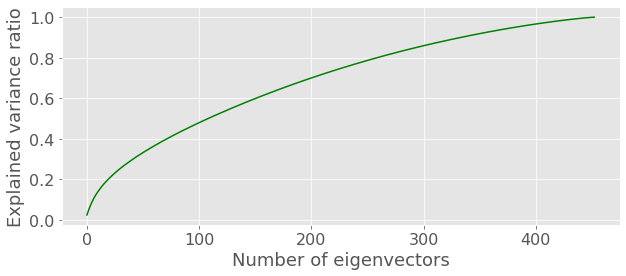

In [15]:
#Maybe plot cumsum instead?
eigenvalues = pcamodel.explained_variance_ratio_
fig1, ax1 = plt.subplots()
ax1.plot(eigenvalues.cumsum(), color = 'green')
#ax1.set_yscale('log')
ax1.set(xlabel = 'Number of eigenvectors', ylabel = 'Explained variance ratio')
plt.savefig('cumsumEigen.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# First we perform parameter tuning on the lambda of Lasso Regression aka L1 penalty
# The search is done in the space np.logspace(-4, 4, 12)

In [17]:
from sklearn.model_selection import KFold
lambdas =  np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_lasso = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Lasso = make_pipeline(StandardScaler(),\
                                   PCA(n_components = 334),\
                                   #PolynomialFeatures(degree = 2, include_bias = False),\
                                   Lasso(alpha = lambda_, random_state = 1337))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Lasso.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Lasso.predict(X_val), y_val))
        
    MSE_lambda_lasso.append(np.mean(MSE_cv))

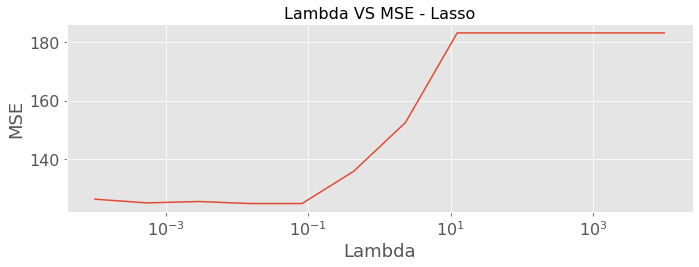

In [18]:
lambdaCV_lasso = pd.Series(MSE_lambda_lasso, index=np.logspace(-4, 4, 12))
fig = plt.figure()
plt.xscale('log')
plt.title('Lambda VS MSE - Lasso')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_lasso)
plt.savefig('Lasso_MSE.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

In [19]:
lambdaCV_lasso

0.000100        126.394901
0.000534        125.135304
0.002848        125.600383
0.015199        124.913207
0.081113        124.902568
0.432876        135.914096
2.310130        152.515485
12.328467       183.049045
65.793322       183.049045
351.119173      183.049045
1873.817423     183.049045
10000.000000    183.049045
dtype: float64

In [20]:
lambdaCV_lasso.nsmallest(1)

0.081113    124.902568
dtype: float64

In [21]:
#Best lambda is 0.081113
# We check the parameters of a fitted model on the whole training data with the optimal parameter

In [22]:
pipe_lasso_whole = Pipeline([('scaler', StandardScaler()),\
                                  ('pca', PCA(n_components = 334)),\
                                  ('lasso', Lasso(alpha = lambdaCV_lasso.idxmin(), random_state = 1337))])
pipe_lasso_whole.fit(X_dev, y_dev)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=334)),
                ('lasso', Lasso(alpha=0.08111308307896872, random_state=1337))])

In [101]:
mse(pipe_lasso_whole.predict(X_dev), y_dev)

116.29710271463195

In [25]:
# Secondly we perform parameter tuning on the lambda of Ridge Regression - L2 penalty
# The search is done in the space np.logspace(-4, 4, 12)

In [26]:
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_Ridge = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Ridge = make_pipeline(StandardScaler(),\
                                   PCA(n_components = 334),\
                                   #PolynomialFeatures(degree = 2, include_bias = False),\
                                   Ridge(alpha = lambda_, random_state = 1337))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Ridge.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Ridge.predict(X_val), y_val))
        
    MSE_lambda_Ridge.append(np.mean(MSE_cv))

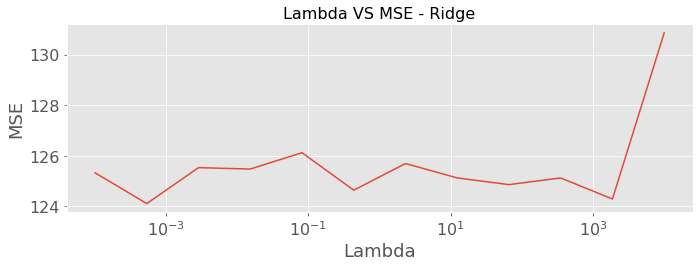

In [27]:
lambdaCV_Ridge = pd.Series(MSE_lambda_Ridge, index=np.logspace(-4, 4, 12))
fig = plt.figure()
plt.xscale('log')
plt.title('Lambda VS MSE - Ridge')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_Ridge)
plt.savefig('Ridge_MSE.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

In [28]:
lambdaCV_Ridge.nsmallest(1)

0.000534    124.109608
dtype: float64

In [29]:
# Best lambda is 1873
# We check the parameters of a fitted model on the whole training data with the optimal parameter

In [30]:
pipe_ridge_whole = Pipeline([('scaler', StandardScaler()),\
                                  ('pca', PCA(n_components = 334)),\
                                  ('ridge', Ridge(alpha = lambdaCV_Ridge.idxmin(), random_state = 1337))])
pipe_ridge_whole.fit(X_dev, y_dev)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=334)),
                ('ridge',
                 Ridge(alpha=0.0005336699231206312, random_state=1337))])

In [98]:
mse(pipe_ridge_whole.predict(X_dev), y_dev)

115.78726339892596

In [32]:
# We see that the lambda for each model are two very different magnitudes
# We now perform a 10-fold cross validation grid search within an elastic net to see how an optimal model would look like

In [33]:
pipe_ElasticNet = make_pipeline(StandardScaler(),
                                PCA(n_components = 334),
                                #PolynomialFeatures(degree = 2, include_bias = False),
                                ElasticNet(random_state = 1337))

gs_ElasticNet = GridSearchCV(estimator=pipe_ElasticNet,
                             param_grid={'elasticnet__alpha': np.logspace(-4, -4, 20),
                                         'elasticnet__l1_ratio': np.linspace(0,1,20)},
                             scoring='neg_mean_squared_error',
                             n_jobs=2,
                             cv=10)

In [34]:
gs_ElasticNet.fit(X_dev, y_dev)
gs_ElasticNet.best_params_

{'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.05263157894736842}

In [35]:
#parameters = (0.0001, 0.05263157894736842)

In [102]:
print(mse(gs_ElasticNet.predict(X_dev), y_dev))

114.87664249501462


In [37]:
# We need same columns as in original data

In [38]:
y_upcoming = df_upcoming['price']

# Same columns as in X - our training data
#X_upcoming = df(data = df_upcoming, columns = X.columns)
X_upcoming = df_upcoming.drop(columns = ['name', 'release_date', 'developer','price', 'id'])

In [39]:
final_model = make_pipeline(StandardScaler(),
                                PCA(n_components = 334),
                                ElasticNet(alpha = gs_ElasticNet.best_params_['elasticnet__alpha'],\
                                           l1_ratio = gs_ElasticNet.best_params_['elasticnet__l1_ratio'],\
                                           random_state = 1337))

In [40]:
final_model.fit(X_dev, y_dev)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=334)),
                ('elasticnet',
                 ElasticNet(alpha=0.0001, l1_ratio=0.05263157894736842,
                            random_state=1337))])

In [41]:
print(mse(final_model.predict(X_dev), y_dev))
print(mse(final_model.predict(X_test), y_test))

114.1739709883455
97.57316761265088


In [42]:
print(mse(final_model.predict(X_upcoming), y_upcoming))

1020.1216968406269


In [43]:
final_model_names = Pipeline([('scaler', StandardScaler()),\
                                  ('pca', PCA(n_components = 334)),\
                                  ('EN', ElasticNet(alpha = gs_ElasticNet.best_params_['elasticnet__alpha'],\
                                                    l1_ratio = gs_ElasticNet.best_params_['elasticnet__l1_ratio'],\
                                                    random_state = 1337))])

In [44]:
print(mse(final_model.predict(X_upcoming), y_upcoming))
print(mse(pipe_lasso_whole.predict(X_upcoming), y_upcoming))
print(mse(pipe_ridge_whole.predict(X_upcoming), y_upcoming))

1020.1216968406269
1116.3532381145844
1070.8649005591267


In [58]:
print(mse(final_model.predict(X_test), y_test))
print(mse(pipe_lasso_whole.predict(X_test), y_test))
print(mse(pipe_ridge_whole.predict(X_test), y_test))

97.57316761265088
96.7852050477894
99.07664611757167


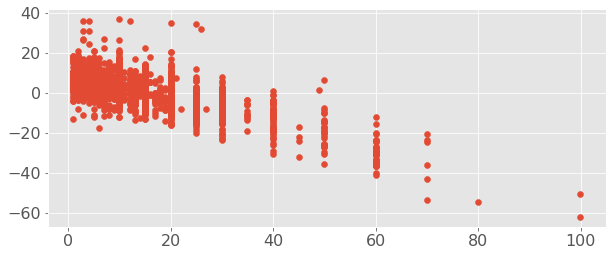

In [45]:
plt.scatter(y_test,(final_model.predict(X_test)-y_test))

In [46]:
residuals = final_model.predict(X_test)-y_test
residuals_norm = (residuals-np.mean(residuals))/np.std(residuals)

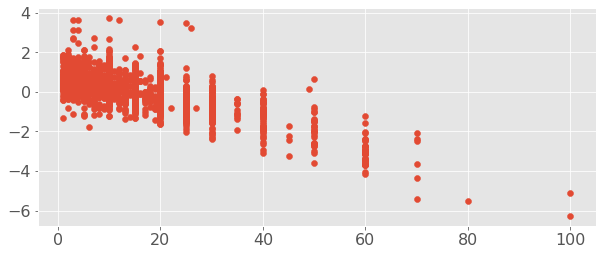

In [47]:
plt.scatter(y_test, residuals_norm)

In [48]:
# pipe_polyEN = make_pipeline(StandardScaler(),
#                                 PCA(n_components = 334),
#                                 PolynomialFeatures(degree = 2, include_bias = False),
#                                 ElasticNet(random_state = 1337))

# gs_polyEN = GridSearchCV(estimator=pipe_polyEN,
#                              param_grid={'elasticnet__alpha': np.logspace(-4, -4, 20),
#                                          'elasticnet__l1_ratio': np.linspace(0,1,20)},
#                              scoring='neg_mean_squared_error',
#                              n_jobs=2,
#                              cv=10)

In [49]:
# gs_polyEN.fit(X_dev, y_dev)

In [50]:
# gs_polyEN.best_params_

In [96]:
poly_model = Pipeline([('scaler', StandardScaler()),\
                                  ('pca', PCA(n_components = 334)),\
                                  ('poly', PolynomialFeatures(degree = 2, include_bias = False)),\
                       ('ridge', Ridge(alpha = 0.5, random_state = 1337))])

In [97]:
import time
start = time.time()
poly_model.fit(X_dev, y_dev)
end = time.time()
print(end-start)

113.49201369285583


In [87]:
len(poly_model.named_steps['lasso'].coef_)

56279